Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
import LogDensityProblems: ValueGradient
import StatisticalRethinking: HMC2, generate_n_samples

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = @__DIR__
cd(ProjDir)

### snippet 9.3

Construct the logdensity problem

In [3]:
struct clip_9_3_model{TY <: AbstractVector, TX <: AbstractVector}
    "Observations."
    y::TY
    "Covariate"
    x::TX
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem:: clip_9_3_model)(θ)
    @unpack y, x, = problem    # extract the data
    @unpack muy, mux = θ     # works on the named tuple too
    ll = 0.0
    ll += loglikelihood(Normal(mux, 1), x)
    ll += loglikelihood(Normal(muy, 1), y)
    ll += logpdf(Normal(0, 1), mux)
    ll += logpdf(Normal(0, 1), muy)
    ll
end

Instantiate the model with data and inits.

In [5]:
Random.seed!(1234591)

N = 100
x = rand(Normal(0, 1), N)
y = rand(Normal(0, 1), N)

p = clip_9_3_model(y, x)
θ = (muy = 0.0, mux=0.0)
p(θ)

-270.6068992198965

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::clip_9_3_model) =
    as((muy = asℝ, mux = asℝ))

problem_transformation (generic function with 1 method)

Wrap the problem with a transformation, then use Flux for the gradient.

In [7]:
P = TransformedLogDensity(problem_transformation(p), p)
∇P = ADgradient(:ForwardDiff, P);

Tune and sample.

In [8]:
chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);

MCMC, adapting ϵ (75 steps)
0.0002 s/step ...done
MCMC, adapting ϵ (25 steps)
0.00064 s/step ...done
MCMC, adapting ϵ (50 steps)
9.4e-5 s/step ...done
MCMC, adapting ϵ (100 steps)
6.9e-5 s/step ...done
MCMC, adapting ϵ (200 steps)
6.5e-5 s/step ...done
MCMC, adapting ϵ (400 steps)
5.7e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
9.3e-5 s/step ...done
MCMC (1000 steps)
5.6e-5 s/step ...done


We use the transformation to obtain the posterior from the chain.

In [9]:
posterior = TransformVariables.transform.(Ref(problem_transformation(p)), get_position.(chain));

Extract the posterior means,

In [10]:
[mean(first, posterior), mean(last, posterior)]

2-element Array{Float64,1}:
  0.014762828233057404
 -0.004578168737638239

Generate fig 9.3

In [11]:
fig = generate_n_samples(p, ∇P);

Display figurs 9.3

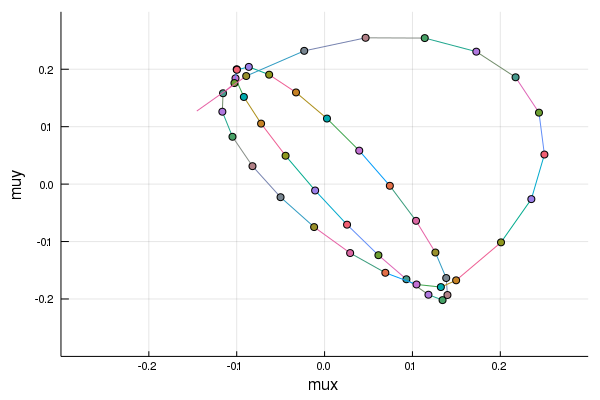

In [12]:
plot(fig)

End of `09/clip-03.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*